# Basic depiction of a FEP workflow using BioSimSpace and Python

In [27]:
import BioSimSpace as BSS
import glob 
BSS.__version__

'2020.1.0+249.gaa2286c'

## 1. With our collection of ligands, figure out which perturbations we should run.

The reliability of FEP calculations is typically higher for transformations with fewer heavy atom changes and some other rules (e.g. no ring formations). LOMAP is a package that contains heuristics for this and is able to come up with a network for us; BioSimSpace contains a function generateNetwork() that uses LOMAP to come up with the perturbation network that visualises the desired perturbations. Additionally, a LOMAP score is calculated which quantifies the likeliness that the FEP prediction will be reliable (0 means unlikely, 1 means highly likely).

This function requires a list of BioSimSpace molecule objects.

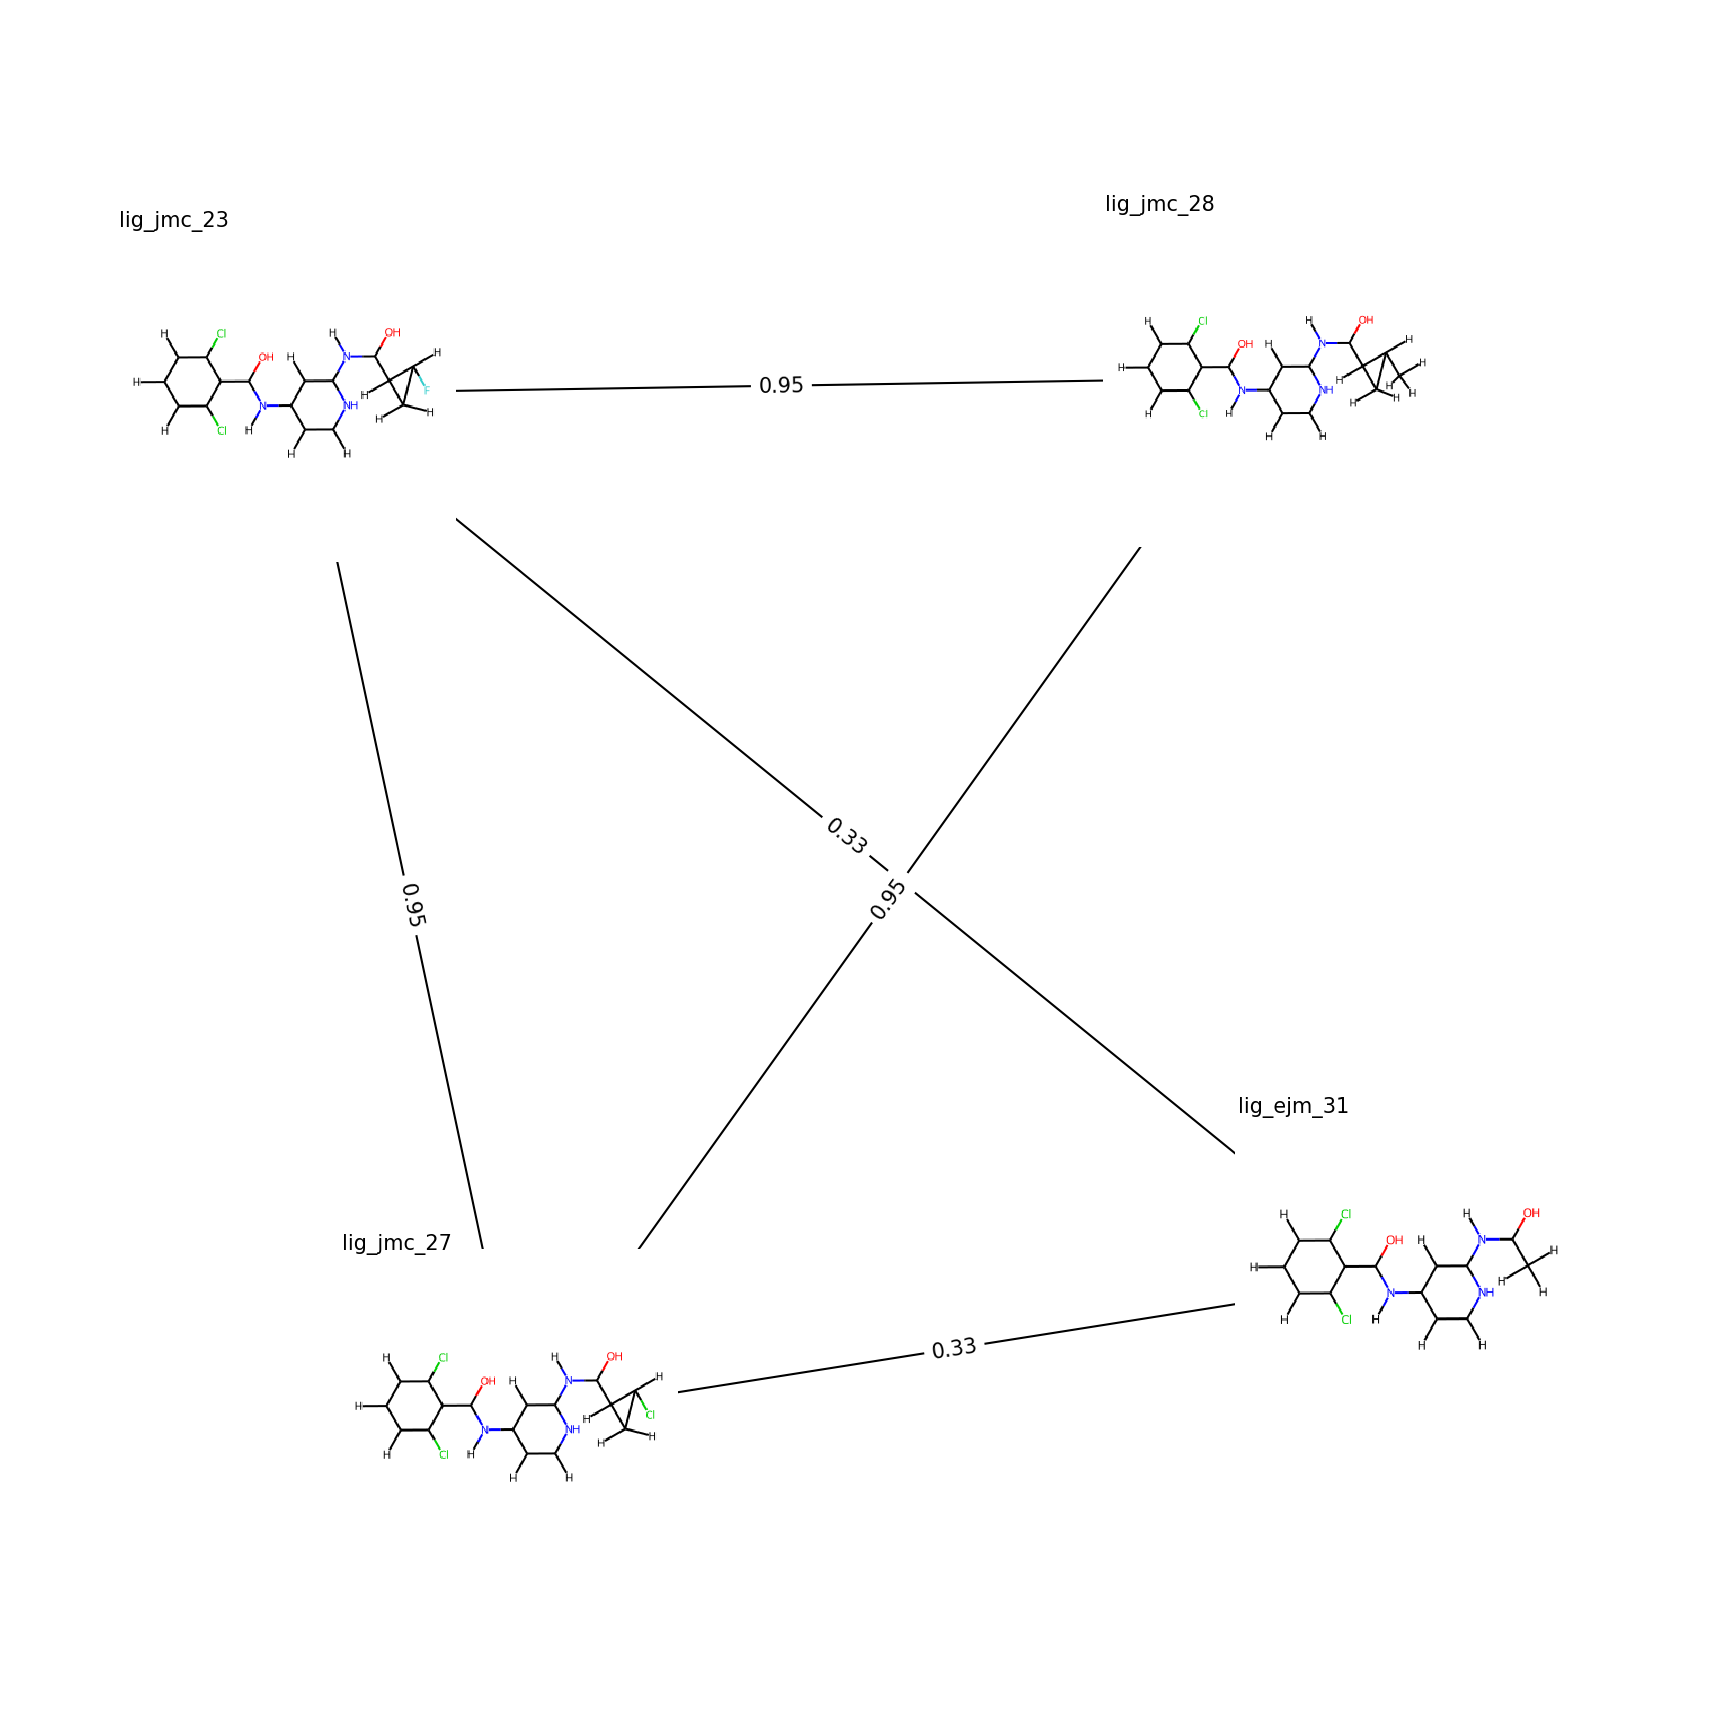

In [29]:
### path_to_ligands = "inputs/ligands/"
ligand_files = glob.glob("{}*.pdb".format(path_to_ligands))

ligands = []
ligand_names = []

for filepath in ligand_files:
    # append the molecule object to a list.
    ligands.append(BSS.IO.readPDB(filepath)[0])
    
    # append the molecule name to another list so that we can show the name in our network.
    ligand_names.append(filepath.split("/")[-1].replace(".pdb",""))

edges, lomap_scores = BSS.Align.generateNetwork(ligands, work_dir="tmp", names=ligand_names)

BioSimSpace uses NetworkX which works with node indices for node names. Let's adjust our list of edges to have ligand names instead of ligand indices:

In [30]:
edges_n = [(ligand_names[edge[0]], ligand_names[edge[1]]) for edge in edges]
edges_n

[('lig_ejm_31', 'lig_jmc_27'),
 ('lig_ejm_31', 'lig_jmc_23'),
 ('lig_jmc_27', 'lig_jmc_23'),
 ('lig_jmc_27', 'lig_jmc_28'),
 ('lig_jmc_23', 'lig_jmc_28')]

Unfortunately, even cutting-edge perturbation network generators such as LOMAP require some manual tweaking. In some cases, a ligand will have poor LOMAP scores on its edges and is therefore likely to be unreliable. To increase its reliability we often want to create an additional edge to this ligand, which can be easily done by appending the edge to our list of edges. 
NB: because we've already run LOMAP this edge will not have an associated LOMAP score.

In [31]:
edges_n.append(('lig_ejm_31', 'lig_jmc_28'))
edges_n

[('lig_ejm_31', 'lig_jmc_27'),
 ('lig_ejm_31', 'lig_jmc_23'),
 ('lig_jmc_27', 'lig_jmc_23'),
 ('lig_jmc_27', 'lig_jmc_28'),
 ('lig_jmc_23', 'lig_jmc_28'),
 ('lig_ejm_31', 'lig_jmc_28')]

## 2. Set up SOMD simulation folders.
First we need to load our pre-parameterised protein and ligands. In our case, we are loading the TYK2 FEP benchmarking set first used by Schrodinger in their JACS publication on FEP+, but is now widely used in the community. For the purposes of this tutorial, force fields used were FF14SB and GAFF2.

In [32]:
path_to_protein = "inputs/protein/tyk2"
path_to_ligands = "inputs/ligands/"

# load the pre-parameterised protein.
protein = BSS.IO.readMolecules(["{}.rst7".format(path_to_protein), "{}.prm7".format(path_to_protein)])[0]

# load the pre-parameterised ligands using our list of ligand names.
# we load the ligands into a dictionary for easy querying in later steps.
ligands_p = {}
for ligand_name in ligand_names:
    ligands_p[ligand_name] = BSS.IO.readMolecules([
                    "{}{}.rst7".format(path_to_ligands,ligand_name),
                    "{}{}.prm7".format(path_to_ligands,ligand_name),
                     ])[0]

Define the Free Energy protocol which contains the general settings. Here we use BSS's standard settings.

see https://biosimspace.org/api/generated/BioSimSpace.Protocol.FreeEnergy.html#BioSimSpace.Protocol.FreeEnergy 

In [26]:
protocol = BSS.Protocol.FreeEnergy()

Now comes the part where we set up the simulation folders. Even though BioSimSpace is able to do this in a few lines, we need to use some more python to loop over our ligands and name our folders correctly.

In [ ]:
# We can loop over each transformation and do the standard BSS setup protocol.
for pert in edges_n:
    
    # get the molecule objects from our dictionary.
    lig_1 = ligands_p[pert[0]]
    lig_2 = ligands_p[pert[1]]

    # for each edge we want to run both directions.
    for ligand_A, ligand_B in [
                        [lig_1, lig_2], 
                        [lig_2, lig_1]
                        ]:
        
        # derive the perturbation name (to name our simulation folder).
        pert_name = pert[0]+"~"+pert[1]
    
        # generate a mapping between the two molecules.
        mapping = BSS.Align.matchAtoms(ligand_A, ligand_B)

        # align ligand A to ligand B.
        ligand_A_a = BSS.Align.rmsdAlign(ligand_A, ligand_B, mapping)

        # merge the aligned molecules into a single object.
        merged = BSS.Align.merge(ligand_A_a, ligand_B, mapping,
                                            allow_ring_breaking=True,
                                            allow_ring_size_change=True
                                            )

        # insert the merged molecules into the protein and solvate the system.
        system = protein + merged

        # no GROMACS install on current system; uncomment in tutorial.
        #system = BSS.Solvent.tip3p(molecule=system, box=3*[10*BSS.Units.Length.nanometer])

        # set up a SOMD folder with standard settings.
        # if you want to run replicates here, a simple iteration loop that with work_dir=pert_name+str(i) would work.
        for i in range(3):
            BSS.FreeEnergy.Binding(
                                                    system, 
                                                    protocol, 
                                                    engine="SOMD",
                                                    work_dir="outputs/SOMD/"+pert_name+"_"+str(i)
                                                    )

## 3. Run simulations & gather MBAR results from simulation outputs.

The collection of set up SOMD folders can be run in parallel on e.g. a computing cluster with slurm. An example job script for such a system would like this:

```
#!/bin/bash
#SBATCH --job-name=FEP
#SBATCH -o somd_slurm.out
#SBATCH -p GTX1080
#SBATCH -n 2
#SBATCH --gres=gpu:1

# load modules.
module load cuda/10.1
module load BSS/dev

date
export OPENMM_PLUGIN_DIR=~/biosimspace.app/lib/plugins/

# run all bound lambda folder jobs on the first GPU.
~/biosimspace.app/bin/python run_bss_somd.py bound &

# run all solvated lambda folder jobs on the second GPU. This will finish sooner than the bound jobs, 
# which will free up this GPU for other jobs. I think?
~/biosimspace.app/bin/python run_bss_somd.py free &

# wait until all jobs are done.
wait

# run MBAR on all this perturbation.
~/biosimspace.app/bin/python run_bss_somd.py mbar &

date
```

The run_bss_somd.py script would look like something along the lines of this:


In [ ]:
#!/bin/python

import BioSimSpace as BSS
import csv
import sys
import os

arg = sys.argv[1]
# get the perturbation name from the path. If nothing 
# was changed this should have been written out by BSS as ligA~ligB.    
pert_name = os.getcwd().split("/")[-1]


if arg == "bound" or arg == "free" or if arg == "vacuum":

    # load the BSS freenrg object associated with this system.
    freenrg = BSS.IO.loadFreenrgObject(".", platform="SOMD")
    
    # run the freenrg object.
    freenrg.run()

elif arg == "mbar":
    
    # load the BSS freenrg object that has the simulations finished.
    freenrg = BSS.IO.loadFreenrgObject(".", platform="SOMD")
    
    pmf_free, pmf_vacuum, free_energy = freenrg.analyse()
    free_energy_diff, free_energy_err = free_energy
    
    # now that we have this value, append it to our summary file.
    with open("../summary.csv", "a") as summaryfile:
        writer = csv.writer(summaryfile)
        writer.writerow([pert_name, free_energy_diff, free_energy_err])

else:
    raise Exception("Please pass any of {} to this script on the "+
                    "commandline.".format(["bound", "free", "vacuum", "mbar"]))

### Some problems with the above:
- we don't want to run vacuum jobs on GPU partitions

- in the current setup does the GPU that finished on solvated actually become available for other jobs?

- replicate MBAR outputs are now being appended line by line. Need to adjust freenrgworkflows (or use an in-between script) to take cross-replicate means. -> there seems to be functionality for this in freenrgworkflows.

- I haven't run any of these edges, so all data from here on is made up. Additionally, I've not been able to find the IC50 values for this set, will have to find the actual values at some point.

## 4. Compute statistics and plot validations.

This is done in a second notebook. See output/freenrg_analysis.ipynb